# Descrição do Notebook
Vídeo de apresentação do chatbot: https://drive.google.com/file/d/1MZGUYezkzfNBi6RNhb8E2ANCFdXLpwQh/view?usp=sharing

Link para a pasta compartilhada: https://drive.google.com/drive/folders/1sWiaP9MKqrGgVey3xkrlAMiKcHJt2lJx?usp=sharing

Trabalho desenvolvido para a disciplina de Inteligência Artificial com o objetivo de construir um chatbot classificador de objetos (instrumentos musicais) que identifique uma foto enviada para o sistema via telegram.

Foram testadas 3 arquiteturas pré-treinadas do PyTorch (MobileNet V3 Small, GoogleNet e EfficientNet), e selecionada a que apresentou o melhor desempenho durante o ajuste do algoritmo.


# Importação de bibliotecas e montagem do Drive

In [74]:
import os # Biblioteca para montar e navegar nos arquivos do Drive
import urllib.request # Biblioteca para download das imagens
from PIL import Image,ImageStat # Biblioteca para construir loader das imagens
import torchvision.transforms as transforms # Biblioteca para transformar as imagens em tensors

# Bibliotecas para construção do dataset
import torch
import torchvision
from torch.utils.data import Dataset
from typing import Any,Tuple

import torchvision.models as models # Modelos pré-treinados do PyTorch
from sklearn.model_selection import train_test_split # Biblioteca para fazer o split do dataset
import numpy as np # Biblioteca para processar o dataset
import torch.nn as nn # Biblioteca para manipular as arquiteturas pré-treinadas do pytorch
from torch import optim # Biblioteca para otimizar o algoritmo
import matplotlib.pyplot as plt # Biblioteca para plotar componentes gráficos
import sklearn.metrics as metrics # Biblioteca para saber as métricas do algoritmo

In [75]:
main_dir = "/content/drive/MyDrive/Rede_Neural_IA"

In [76]:
os.chdir(main_dir)

# Download Imagens no Drive

In [77]:
def download_images(main_dir,urls_filename):
    class_name = urls_filename.split('.')[-2]
    output_dir = main_dir+os.sep+class_name
    os.makedirs(output_dir,exist_ok=True)
    with open(urls_filename) as f:
        for url in f:
            img_filename = url.split('/')[-1].replace("\n","")
            print(img_filename)
            try:
                response = urllib.request.urlopen(url)
                open(output_dir+'/'+img_filename,mode="wb+").write(response.read())
            except:
                print('nao conseguiu baixar ',url)

In [78]:
#download_images(main_dir,'saxofones.csv')
#download_images(main_dir,'clarinetes.csv')
#download_images(main_dir,'trompetes.csv')
#download_images(main_dir,'flautas.csv')
#download_images(main_dir,'violinos.csv')
#download_images(main_dir,'violoes.csv')
#download_images(main_dir,'guitarras.csv')
#download_images(main_dir,'contrabaixos.csv')
#download_images(main_dir,'teclados.csv')
#download_images(main_dir,'baterias.csv')

# Teste loader de imagens

In [79]:
def image_loader(img):
    return Image.open(img).convert("RGB")

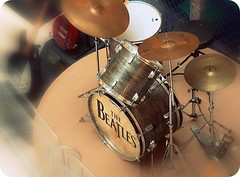

In [80]:
img = image_loader('./bateria/450842838_abcafde9b6_m.jpg')

img

In [81]:
transform = transforms.Compose([transforms.Resize((80,80)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                            ])

In [82]:
img_tensor = transform(img)

# Construção do Dataset

In [83]:
dir = './'

In [84]:
for file_names in os.scandir('./'):
    print(file_names)

<DirEntry 'bateria.csv'>
<DirEntry 'bateria'>
<DirEntry 'clarinete'>
<DirEntry 'contrabaixo'>
<DirEntry 'flauta'>
<DirEntry 'guitarra'>
<DirEntry 'saxofone'>
<DirEntry 'teclado'>
<DirEntry 'trompete'>
<DirEntry 'violao'>
<DirEntry 'violino'>
<DirEntry 'clarinete.csv'>
<DirEntry 'contrabaixo.csv'>
<DirEntry 'flauta.csv'>
<DirEntry 'guitarra.csv'>
<DirEntry 'saxofone.csv'>
<DirEntry 'teclado.csv'>
<DirEntry 'trompete.csv'>
<DirEntry 'violino.csv'>
<DirEntry 'violao.csv'>
<DirEntry 'best_model.pth'>
<DirEntry 'image_name.jpg'>
<DirEntry 'imagem_recebida.jpg'>
<DirEntry 'Trabalho 3.ipynb'>


In [85]:
classes = [d.name for d in os.scandir(dir) if d.is_dir()]

In [86]:
classes

['bateria',
 'clarinete',
 'contrabaixo',
 'flauta',
 'guitarra',
 'saxofone',
 'teclado',
 'trompete',
 'violao',
 'violino']

In [87]:
class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

In [88]:
class_to_idx

{'bateria': 0,
 'clarinete': 1,
 'contrabaixo': 2,
 'flauta': 3,
 'guitarra': 4,
 'saxofone': 5,
 'teclado': 6,
 'trompete': 7,
 'violao': 8,
 'violino': 9}

In [89]:
dataset = torchvision.datasets.DatasetFolder(root=dir,loader = image_loader,extensions='jpg',transform=transform )

In [90]:
instances = []
for target_class in sorted(class_to_idx.keys()):
        class_index = class_to_idx[target_class]
        target_dir = os.path.join(dir, target_class)
        for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                item = path, class_index
                instances.append(item)

In [91]:
instances

[('./bateria/10045916674_18687c2bb0_n.jpg', 0),
 ('./bateria/1011141418_61554f7997_m.jpg', 0),
 ('./bateria/10883031785_3483140b7c_n.jpg', 0),
 ('./bateria/1094016223_1034a43d9b_m.jpg', 0),
 ('./bateria/11048683793_05541e99ea_m.jpg', 0),
 ('./bateria/11157039825_915fc216e5_n.jpg', 0),
 ('./bateria/11281660704_9fde6da7d9_m.jpg', 0),
 ('./bateria/11312844364_31567149a6_w.jpg', 0),
 ('./bateria/11312847694_324343e652_w.jpg', 0),
 ('./bateria/11500394675_553258627b_w.jpg', 0),
 ('./bateria/12204488795_8c501aecd4_m.jpg', 0),
 ('./bateria/12204952044_bbfc4de456_m.jpg', 0),
 ('./bateria/12659371975_f8ea5795e6_n.jpg', 0),
 ('./bateria/12659841164_dc5f49a81c_n.jpg', 0),
 ('./bateria/12659843784_be44d4219d_m.jpg', 0),
 ('./bateria/1279848118_b32be4a7f5_n.jpg', 0),
 ('./bateria/12804480225_e0d37b1f3b_w.jpg', 0),
 ('./bateria/12804531455_121988c30b_m.jpg', 0),
 ('./bateria/12804883864_49b185ff3c_m.jpg', 0),
 ('./bateria/12980784803_024d1ae9d5_n.jpg', 0),
 ('./bateria/14177354900_406d46174c_n.jpg',

In [92]:
class InstrumentosDataset(Dataset):
    def __init__(self,dir,transform=None,target_transform=None,loader = None):
        self.main_dir = dir
        self.transform = transform
        self.target_transform = target_transform
        self.classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        self.classes.sort()
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.targets = []
        self.instances = self.make_instances()
        self.loader = loader
        
        if loader is None:
            self.loader = lambda x: Image.open(x).convert('RGB')

    def make_instances(self):
        instances = []
        targets = []
        for target_class in sorted(self.class_to_idx.keys()):
                class_index = self.class_to_idx[target_class]
                target_dir = os.path.join(self.main_dir, target_class)
                for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                    for fname in sorted(fnames):
                        path = os.path.join(root, fname)
                        item = path, class_index
                        targets.append(class_index)
                        instances.append(item)
        self.targets = torch.tensor(targets)
        return instances
    def __getitem__(self,index:int) -> Tuple[Any,Any]:
        path, target = self.instances[index]
        instance = self.loader(path)
        if self.transform is not None:
            instance = self.transform(instance)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return instance,target
    def __len__(self) -> int:
        return len(self.instances)



In [93]:
dataset = InstrumentosDataset(dir,transform=transform)

# Treinamento da Rede

In [94]:
ds = dataset

In [95]:
np.unique(ds.targets,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([199, 199, 185, 199, 199, 200, 199, 199, 199, 200]))

In [96]:
# Split de Treino e Validação
bs = 64
train_idx, temp_idx = train_test_split(np.arange(len(ds)),test_size=0.3,shuffle=True,stratify=ds.targets)
valid_idx, test_idx = train_test_split(temp_idx,test_size=0.5,shuffle=True,stratify=ds.targets[temp_idx])
 
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)
test_sampler  = torch.utils.data.SubsetRandomSampler(test_idx)
 
dl_train = torch.utils.data.DataLoader(ds,batch_size=bs,sampler=train_sampler)
dl_valid = torch.utils.data.DataLoader(ds,batch_size=bs,sampler=valid_sampler)
dl_test  = torch.utils.data.DataLoader(ds,batch_size=bs,sampler=test_sampler)

In [97]:
np.unique(ds.targets[train_idx],return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([139, 139, 130, 139, 140, 140, 139, 139, 139, 140]))

In [98]:
np.unique(ds.targets[temp_idx],return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([60, 60, 55, 60, 59, 60, 60, 60, 60, 60]))

In [99]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [100]:
device

device(type='cpu')

In [101]:
#torch.cuda.get_device_properties(0)

In [102]:
x,y = next(iter(dl_train))

## Arquitetura mobilenet_v3_small

In [103]:
model = torchvision.models.mobilenet_v3_small(pretrained=True)

In [104]:
# Alteração da saída da arquitetura no modelo
model.classifier[3] = nn.Linear(1024,10)

In [105]:
# Envio do modelo para a GPU
model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride

In [106]:
#modules = list(model.features.children())[:-2] # tirando as camadas 11 e 12

In [107]:
#len(modules)
#model.features = nn.Sequential(*modules)
#model.to(device)

In [108]:
criterion = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(),lr=0.1)

In [109]:
epochs = 100
loss_train = []
loss_eval  = []
stop = False
epoch = 0
lowest_loss_eval = 10000
last_best_result = 0

In [110]:
while (not stop):
    #wandb.watch(model)
    model.train()
    lloss = []
    for x,y in dl_train:
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        closs = criterion(pred,y)
        closs.backward()
        opt.step()
        opt.zero_grad()
        lloss.append(closs.item())
        #print(closs.item())
    loss_train.append(np.mean(lloss))
    llos = []
    model.eval()
    lres = []
    ytrue = []
    with torch.no_grad():
        for data,y in dl_valid:
            data = data.to(device)

            pred = model(data)
            closs = criterion(pred.cpu(),y)
            lloss.append(closs.item())
            res  = pred.argmax(dim=1).cpu().tolist()
            lres += res
            ytrue += y
    avg_loss_eval = np.mean(lloss)
    loss_eval.append(avg_loss_eval)
    #wandb.log({"loss_eval": avg_loss_eval,"loss_train":loss_train[-1]})
    if avg_loss_eval < lowest_loss_eval:
        lowest_loss_eval = avg_loss_eval 
        last_best_result = 0
        print("Best model found! saving...")
        actual_state = {'model':model.state_dict(),'opt':opt.state_dict(),'epoch':epoch,'loss':lowest_loss_eval,'loss_train':loss_train,'loss_eval':loss_eval}
        torch.save(actual_state,'best_model.pth')
    last_best_result += 1
    if last_best_result > 10:
        stop = True
    print("epoch %d loss_train %4.3f loss_eval %4.3f last_best %d"%(epoch,loss_train[-1],loss_eval[-1],last_best_result))
    epoch += 1

Best model found! saving...
epoch 0 loss_train 2.200 loss_eval 2.224 last_best 1
Best model found! saving...
epoch 1 loss_train 1.709 loss_eval 1.813 last_best 1
Best model found! saving...
epoch 2 loss_train 1.277 loss_eval 1.429 last_best 1
Best model found! saving...
epoch 3 loss_train 0.887 loss_eval 1.185 last_best 1
Best model found! saving...
epoch 4 loss_train 0.537 loss_eval 0.912 last_best 1
Best model found! saving...
epoch 5 loss_train 0.321 loss_eval 0.693 last_best 1
Best model found! saving...
epoch 6 loss_train 0.201 loss_eval 0.608 last_best 1
Best model found! saving...
epoch 7 loss_train 0.123 loss_eval 0.544 last_best 1
Best model found! saving...
epoch 8 loss_train 0.071 loss_eval 0.510 last_best 1
Best model found! saving...
epoch 9 loss_train 0.054 loss_eval 0.481 last_best 1
Best model found! saving...
epoch 10 loss_train 0.032 loss_eval 0.478 last_best 1
epoch 11 loss_train 0.037 loss_eval 0.492 last_best 2
Best model found! saving...
epoch 12 loss_train 0.030 

In [111]:
recover = torch.load('best_model.pth')

In [112]:
model.load_state_dict(recover['model'],strict=False)
opt.load_state_dict(recover['opt'])
loss_train = recover['loss_train']
loss_eval  = recover['loss_eval']
stop = False
epoch = recover['epoch']
lowest_loss_eval = recover['loss']
last_best_result = 0

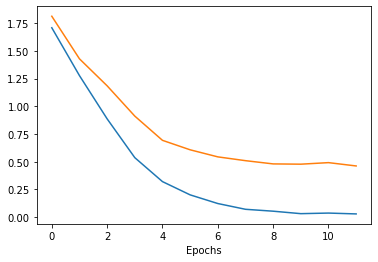

In [113]:
plt.ion()
fig = plt.figure()
plt.plot(loss_train[1:])
plt.plot(loss_eval[1:])
plt.xlabel('Epochs')
plt.show()

In [114]:
model.eval()
lres = []
ytrue = []
with torch.no_grad():
    for data,target in dl_test:
        data = data.to(device)
        pred = model(data)
        res  = pred.argmax(dim=1).cpu().tolist()
        lres += res
        ytrue += target
        print(lres)

[5, 2, 5, 9, 1, 1, 3, 9, 3, 3, 3, 8, 5, 1, 7, 5, 6, 7, 0, 3, 1, 8, 9, 0, 5, 0, 8, 9, 6, 8, 0, 9, 3, 4, 1, 6, 9, 6, 7, 0, 4, 2, 8, 9, 2, 3, 3, 7, 5, 0, 5, 6, 4, 1, 0, 3, 7, 6, 7, 0, 2, 8, 4, 5]
[5, 2, 5, 9, 1, 1, 3, 9, 3, 3, 3, 8, 5, 1, 7, 5, 6, 7, 0, 3, 1, 8, 9, 0, 5, 0, 8, 9, 6, 8, 0, 9, 3, 4, 1, 6, 9, 6, 7, 0, 4, 2, 8, 9, 2, 3, 3, 7, 5, 0, 5, 6, 4, 1, 0, 3, 7, 6, 7, 0, 2, 8, 4, 5, 4, 8, 7, 4, 4, 9, 1, 0, 8, 7, 9, 9, 2, 4, 9, 9, 1, 1, 6, 3, 7, 6, 8, 1, 3, 6, 9, 9, 9, 6, 7, 5, 6, 3, 1, 7, 0, 6, 3, 1, 9, 5, 7, 1, 3, 2, 7, 5, 0, 3, 8, 6, 0, 6, 8, 0, 5, 0, 5, 6, 5, 6, 6, 2]
[5, 2, 5, 9, 1, 1, 3, 9, 3, 3, 3, 8, 5, 1, 7, 5, 6, 7, 0, 3, 1, 8, 9, 0, 5, 0, 8, 9, 6, 8, 0, 9, 3, 4, 1, 6, 9, 6, 7, 0, 4, 2, 8, 9, 2, 3, 3, 7, 5, 0, 5, 6, 4, 1, 0, 3, 7, 6, 7, 0, 2, 8, 4, 5, 4, 8, 7, 4, 4, 9, 1, 0, 8, 7, 9, 9, 2, 4, 9, 9, 1, 1, 6, 3, 7, 6, 8, 1, 3, 6, 9, 9, 9, 6, 7, 5, 6, 3, 1, 7, 0, 6, 3, 1, 9, 5, 7, 1, 3, 2, 7, 5, 0, 3, 8, 6, 0, 6, 8, 0, 5, 0, 5, 6, 5, 6, 6, 2, 8, 9, 7, 4, 6, 1, 2, 3, 5, 3, 7, 2, 9

In [115]:
metrics.confusion_matrix(ytrue,lres)

array([[ 7,  1,  3,  1,  0,  4,  2,  6,  3,  3],
       [ 3, 15,  0,  3,  1,  2,  0,  4,  1,  1],
       [ 3,  2,  3,  2,  1,  3,  3,  4,  3,  3],
       [ 3,  1,  6,  9,  0,  4,  1,  3,  3,  0],
       [ 2,  1,  4,  2,  8,  1,  2,  1,  7,  2],
       [ 5,  4,  2,  3,  3,  7,  1,  1,  2,  2],
       [ 1,  0,  1,  2,  3,  0, 20,  0,  2,  1],
       [ 3,  4,  2,  4,  0,  4,  2,  8,  3,  0],
       [ 4,  0,  3,  4,  1,  0,  4,  2, 11,  1],
       [ 1,  1,  4,  0,  1,  1,  0,  0,  0, 22]])

In [116]:
print('Accuracy:  %4.3f'%metrics.accuracy_score(ytrue,lres))
print('Precision: %4.3f'%metrics.precision_score(ytrue,lres,average='macro'))
print('Recall: %4.3f'%metrics.recall_score(ytrue,lres,average='macro'))
print('F1_score: %4.3f'%metrics.f1_score(ytrue,lres,average='macro'))

Accuracy:  0.370
Precision: 0.365
Recall: 0.368
F1_score: 0.363


## Arquitetura EfficientNet-B7



In [130]:
model = models.efficientnet_b7(pretrained=True)

In [131]:
model

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivatio

In [132]:
# Alteração da saída da arquitetura no modelo
model.classifier[1] = nn.Linear(2560, 10)

In [133]:
# Envio do modelo para a GPU
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivatio

In [134]:
criterion = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(),lr=0.1)

In [135]:
epochs = 100
loss_train = []
loss_eval  = []
stop = False
epoch = 0
lowest_loss_eval = 10000
last_best_result = 0

In [136]:
while (not stop):
    #wandb.watch(model)
    model.train()
    lloss = []
    for x,y in dl_train:
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        closs = criterion(pred,y)
        closs.backward()
        opt.step()
        opt.zero_grad()
        lloss.append(closs.item())
        #print(closs.item())
    loss_train.append(np.mean(lloss))
    llos = []
    model.eval()
    lres = []
    ytrue = []
    with torch.no_grad():
        for data,y in dl_valid:
            data = data.to(device)

            pred = model(data)
            closs = criterion(pred.cpu(),y)
            lloss.append(closs.item())
            res  = pred.argmax(dim=1).cpu().tolist()
            lres += res
            ytrue += y
    avg_loss_eval = np.mean(lloss)
    loss_eval.append(avg_loss_eval)
    #wandb.log({"loss_eval": avg_loss_eval,"loss_train":loss_train[-1]})
    if avg_loss_eval < lowest_loss_eval:
        lowest_loss_eval = avg_loss_eval 
        last_best_result = 0
        print("Best model found! saving...")
        actual_state = {'model':model.state_dict(),'opt':opt.state_dict(),'epoch':epoch,'loss':lowest_loss_eval,'loss_train':loss_train,'loss_eval':loss_eval}
        torch.save(actual_state,'best_model.pth')
    last_best_result += 1
    if last_best_result > 10:
        stop = True
    print("epoch %d loss_train %4.3f loss_eval %4.3f last_best %d"%(epoch,loss_train[-1],loss_eval[-1],last_best_result))
    epoch += 1

Best model found! saving...
epoch 0 loss_train 2.225 loss_eval 2.201 last_best 1
Best model found! saving...
epoch 1 loss_train 1.807 loss_eval 1.819 last_best 1
Best model found! saving...
epoch 2 loss_train 1.348 loss_eval 1.412 last_best 1


KeyboardInterrupt: ignored

In [ ]:
recover = torch.load('best_model.pth')

In [ ]:
model.load_state_dict(recover['model'],strict=False)
opt.load_state_dict(recover['opt'])
loss_train = recover['loss_train']
loss_eval  = recover['loss_eval']
stop = False
epoch = recover['epoch']
lowest_loss_eval = recover['loss']
last_best_result = 0

In [ ]:
plt.ion()
fig = plt.figure()
plt.plot(loss_train[1:])
plt.plot(loss_eval[1:])
plt.xlabel('Epochs')
plt.show()

In [ ]:
model.eval()
lres = []
ytrue = []
with torch.no_grad():
    for data,target in dl_test:
        data = data.to(device)
        pred = model(data)
        res  = pred.argmax(dim=1).cpu().tolist()
        lres += res
        ytrue += target
        print(lres)

In [ ]:
metrics.confusion_matrix(ytrue,lres)

In [ ]:
print('Accuracy:  %4.3f'%metrics.accuracy_score(ytrue,lres))
print('Precision: %4.3f'%metrics.precision_score(ytrue,lres,average='macro'))
print('Recall: %4.3f'%metrics.recall_score(ytrue,lres,average='macro'))
print('F1_score: %4.3f'%metrics.f1_score(ytrue,lres,average='macro'))

### Seleção da melhor arquitetura e teste de predição

In [ ]:
img = image_loader('./bateria/450842838_abcafde9b6_m.jpg')

In [ ]:
transform = transforms.Compose([transforms.Resize((80,80)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                            ])

In [ ]:
img_tensor = transform(img)

## Arquitetura GoogleNet

Deixei a arquitetura GoogleNet por último pois foi a que apresentou os melhores resultados das métricas


In [117]:
model = models.googlenet(pretrained=True)

In [118]:
model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [119]:
# Alteração da saída da arquitetura no modelo
model.fc = nn.Linear(1024,10)

In [120]:
# Envio do modelo para a GPU
model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [121]:
criterion = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(),lr=0.1)

In [122]:
epochs = 100
loss_train = []
loss_eval  = []
stop = False
epoch = 0
lowest_loss_eval = 10000
last_best_result = 0

In [123]:
while (not stop):
    #wandb.watch(model)
    model.train()
    lloss = []
    for x,y in dl_train:
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        closs = criterion(pred,y)
        closs.backward()
        opt.step()
        opt.zero_grad()
        lloss.append(closs.item())
        #print(closs.item())
    loss_train.append(np.mean(lloss))
    llos = []
    model.eval()
    lres = []
    ytrue = []
    with torch.no_grad():
        for data,y in dl_valid:
            data = data.to(device)

            pred = model(data)
            closs = criterion(pred.cpu(),y)
            lloss.append(closs.item())
            res  = pred.argmax(dim=1).cpu().tolist()
            lres += res
            ytrue += y
    avg_loss_eval = np.mean(lloss)
    loss_eval.append(avg_loss_eval)
    #wandb.log({"loss_eval": avg_loss_eval,"loss_train":loss_train[-1]})
    if avg_loss_eval < lowest_loss_eval:
        lowest_loss_eval = avg_loss_eval 
        last_best_result = 0
        print("Best model found! saving...")
        actual_state = {'model':model.state_dict(),'opt':opt.state_dict(),'epoch':epoch,'loss':lowest_loss_eval,'loss_train':loss_train,'loss_eval':loss_eval}
        torch.save(actual_state,'best_model.pth')
    last_best_result += 1
    if last_best_result > 10:
        stop = True
    print("epoch %d loss_train %4.3f loss_eval %4.3f last_best %d"%(epoch,loss_train[-1],loss_eval[-1],last_best_result))
    epoch += 1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Best model found! saving...
epoch 0 loss_train 2.032 loss_eval 2.016 last_best 1
Best model found! saving...
epoch 1 loss_train 1.195 loss_eval 1.272 last_best 1
Best model found! saving...
epoch 2 loss_train 0.619 loss_eval 0.804 last_best 1
Best model found! saving...
epoch 3 loss_train 0.261 loss_eval 0.480 last_best 1
Best model found! saving...
epoch 4 loss_train 0.097 loss_eval 0.363 last_best 1
Best model found! saving...
epoch 5 loss_train 0.037 loss_eval 0.324 last_best 1
Best model found! saving...
epoch 6 loss_train 0.026 loss_eval 0.309 last_best 1
epoch 7 loss_train 0.021 loss_eval 0.310 last_best 2
epoch 8 loss_train 0.015 loss_eval 0.313 last_best 3
epoch 9 loss_train 0.014 loss_eval 0.309 last_best 4
epoch 10 loss_train 0.011 loss_eval 0.310 last_best 5
epoch 11 loss_train 0.012 loss_eval 0.321 last_best 6
epoch 12 loss_train 0.009 loss_eval 0.315 last_best 7
epoch 13 loss_train 0.010 loss_eval 0.318 last_best 8
epoch 14 loss_train 0.011 loss_eval 0.315 last_best 9
epoc

In [124]:
recover = torch.load('best_model.pth')

In [125]:
model.load_state_dict(recover['model'],strict=False)
opt.load_state_dict(recover['opt'])
loss_train = recover['loss_train']
loss_eval  = recover['loss_eval']
stop = False
epoch = recover['epoch']
lowest_loss_eval = recover['loss']
last_best_result = 0

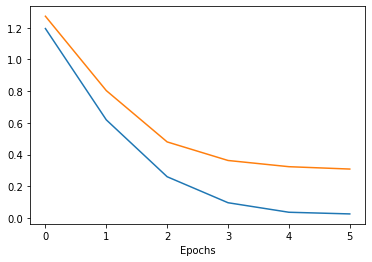

In [126]:
plt.ion()
fig = plt.figure()
plt.plot(loss_train[1:])
plt.plot(loss_eval[1:])
plt.xlabel('Epochs')
plt.show()

In [127]:
model.eval()
lres = []
ytrue = []
with torch.no_grad():
    for data,target in dl_test:
        data = data.to(device)
        pred = model(data)
        res  = pred.argmax(dim=1).cpu().tolist()
        lres += res
        ytrue += target
        print(lres)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


[5, 9, 1, 2, 2, 1, 9, 0, 3, 0, 3, 6, 3, 7, 0, 4, 7, 9, 6, 1, 2, 8, 5, 1, 0, 5, 1, 6, 4, 3, 3, 7, 8, 3, 3, 3, 8, 8, 1, 5, 5, 9, 7, 7, 6, 7, 8, 4, 1, 9, 5, 2, 1, 6, 2, 8, 5, 6, 6, 3, 5, 1, 8, 2]
[5, 9, 1, 2, 2, 1, 9, 0, 3, 0, 3, 6, 3, 7, 0, 4, 7, 9, 6, 1, 2, 8, 5, 1, 0, 5, 1, 6, 4, 3, 3, 7, 8, 3, 3, 3, 8, 8, 1, 5, 5, 9, 7, 7, 6, 7, 8, 4, 1, 9, 5, 2, 1, 6, 2, 8, 5, 6, 6, 3, 5, 1, 8, 2, 1, 8, 2, 3, 6, 3, 1, 6, 6, 3, 1, 9, 0, 2, 1, 9, 1, 7, 8, 5, 1, 9, 0, 1, 0, 6, 1, 1, 8, 2, 7, 9, 0, 0, 5, 3, 7, 8, 6, 5, 6, 2, 8, 9, 0, 3, 0, 8, 9, 9, 3, 3, 3, 1, 6, 8, 2, 1, 8, 2, 0, 7, 8, 2]
[5, 9, 1, 2, 2, 1, 9, 0, 3, 0, 3, 6, 3, 7, 0, 4, 7, 9, 6, 1, 2, 8, 5, 1, 0, 5, 1, 6, 4, 3, 3, 7, 8, 3, 3, 3, 8, 8, 1, 5, 5, 9, 7, 7, 6, 7, 8, 4, 1, 9, 5, 2, 1, 6, 2, 8, 5, 6, 6, 3, 5, 1, 8, 2, 1, 8, 2, 3, 6, 3, 1, 6, 6, 3, 1, 9, 0, 2, 1, 9, 1, 7, 8, 5, 1, 9, 0, 1, 0, 6, 1, 1, 8, 2, 7, 9, 0, 0, 5, 3, 7, 8, 6, 5, 6, 2, 8, 9, 0, 3, 0, 8, 9, 9, 3, 3, 3, 1, 6, 8, 2, 1, 8, 2, 0, 7, 8, 2, 1, 5, 0, 5, 7, 1, 1, 5, 8, 0, 6, 9, 0

In [128]:
metrics.confusion_matrix(ytrue,lres)

array([[15,  4,  2,  2,  0,  2,  0,  2,  1,  2],
       [ 2, 17,  1,  4,  0,  2,  0,  4,  0,  0],
       [ 4,  0, 10,  4,  2,  2,  1,  1,  2,  1],
       [ 1,  8,  0,  9,  0,  3,  1,  5,  2,  1],
       [ 0,  2,  1,  0,  8,  1,  0,  1, 14,  3],
       [ 1,  5,  5,  1,  0,  9,  1,  4,  2,  2],
       [ 0,  1,  0,  2,  0,  0, 26,  1,  0,  0],
       [ 3,  3,  4,  4,  0,  5,  0, 10,  0,  1],
       [ 3,  3,  2,  5,  4,  2,  0,  1, 10,  0],
       [ 0,  2,  2,  1,  1,  0,  0,  1,  2, 21]])

In [129]:
print('Accuracy:  %4.3f'%metrics.accuracy_score(ytrue,lres))
print('Precision: %4.3f'%metrics.precision_score(ytrue,lres,average='macro'))
print('Recall: %4.3f'%metrics.recall_score(ytrue,lres,average='macro'))
print('F1_score: %4.3f'%metrics.f1_score(ytrue,lres,average='macro'))

Accuracy:  0.455
Precision: 0.464
Recall: 0.454
F1_score: 0.452


# Teste de predição com a arquitetura selecionada GoogleNet

In [155]:
class_to_idx

{'bateria': 0,
 'clarinete': 1,
 'contrabaixo': 2,
 'flauta': 3,
 'guitarra': 4,
 'saxofone': 5,
 'teclado': 6,
 'trompete': 7,
 'violao': 8,
 'violino': 9}

In [219]:
def pred_img(img):
  img = image_loader(img)
  img_tensor = transform(img)
  img_tensor.shape
  img_tensor = img_tensor.unsqueeze(0)
  img_tensor.size()
  model.eval()
  with torch.no_grad():
      data = img_tensor.to(device)
      pred = model(data)
      res  = pred.argmax(dim=1).cpu().tolist()
      print("Classe predita: ", classes[res[0]])
  return img

Classe predita:  saxofone


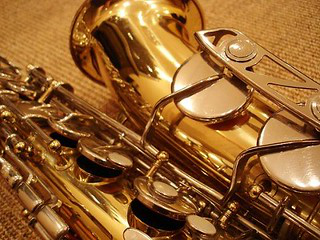

In [216]:
pred_img('saxofone/381725818_659744623b_n.jpg')

Classe predita:  violino


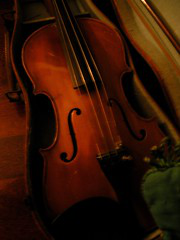

In [217]:
pred_img('violino/304157621_8b36b7747a_m.jpg')

# Integração com o Telegram

In [139]:
!pip install pytelegrambotapi --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 157 kB 9.9 MB/s 
  Created wheel for pytelegrambotapi: filename=pyTelegramBotAPI-4.5.1-py3-none-any.whl size=138116 sha256=35b144bbb5ca723ef6e8835d3bc098ca59ac21ac979ce85ae2cdbbb546d0fc8e
  Stored in directory: /root/.cache/pip/wheels/9a/90/69/89e4e68c819633d933753827fd4f3a22987e162b7404b092b5
Successfully built pytelegrambotapi


In [269]:
import telebot
chave = ("5267043465:AAFEcnGNMHFpx8eZ9fA7jShtdZqA_LM6KbI")
bot = telebot.TeleBot(chave)

In [270]:
import requests  
from io import BytesIO

In [ ]:
@bot.message_handler(commands=["start"])
def inicia(mensagem_usuario):
    bot.send_message(mensagem_usuario.chat.id, "Olá, eu sou o bot músico! Me envie o Link da foto de um instrumento e eu vou tentar advinhá-lo.")

@bot.message_handler()
def responder(mensagem_usuario):    
    processaLink(mensagem_usuario)

@bot.message_handler(content_types=['photo'])
def photo(arquivo):
    res = processaFoto(arquivo)
        
def processaFoto(mensagem):
    print('message.photo =', mensagem.photo)
    fileID = mensagem.photo[-1].file_id
    print('fileID =', fileID)
    file = bot.get_file(fileID)
    print ('file.file_path =', file.file_path)
    img_data = requests.get('https://api.telegram.org/file/bot' + chave + file.file_path).content
    
    with open('imagem_recebida.jpg', 'wb') as handler:
      handler.write(img_data)

    try:
      image_loader(img_data)
    except:
      bot.send_message(mensagem.chat.id, 'A API do Telegram não retornou o link da imagem, envie um link ao invés de um arquivo para ser processado.')

def processaLink(url):
  try:
    response = requests.get(url.text)
    img = Image.open(BytesIO(response.content))
    img_tensor = transform(img)
    img_tensor.shape
    img_tensor = img_tensor.unsqueeze(0)
    img_tensor.size()
    model.eval()
    with torch.no_grad():
        data = img_tensor.to(device)
        pred = model(data)
        res  = pred.argmax(dim=1).cpu().tolist()
    bot.send_message(url.chat.id, 'O instrumento da foto me parece ser um ' + classes[res[0]] + '!!!')
  except:
    bot.send_message(url.chat.id, 'Me envie uma foto ou um link da imagem de instrumento e eu direi o que eu acho que ele é!')

bot.polling()

message.photo = [<telebot.types.PhotoSize object at 0x7efbae272750>, <telebot.types.PhotoSize object at 0x7efbae272350>, <telebot.types.PhotoSize object at 0x7efbac21e110>]
fileID = AgACAgEAAxkBAAIGhWKwDX7Qvf3Ssh6F3mEcOa8aWgemAAK3qjEbM-KBRRoLqgna-cOnAQADAgADeAADKAQ
file.file_path = photos/file_6.jpg
message.photo = [<telebot.types.PhotoSize object at 0x7efbae272b50>, <telebot.types.PhotoSize object at 0x7efbac237c90>, <telebot.types.PhotoSize object at 0x7efbac237550>, <telebot.types.PhotoSize object at 0x7efbac21e490>]
fileID = AgACAgEAAxkBAAIGkWKwDgjwEtSDf2CwIoY-FW8zrsc5AAK4qjEbM-KBRWAHyOjTkjf-AQADAgADeAADKAQ
file.file_path = photos/file_7.jpg
message.photo = [<telebot.types.PhotoSize object at 0x7efbae272a10>, <telebot.types.PhotoSize object at 0x7efbae272b50>, <telebot.types.PhotoSize object at 0x7efbae272250>]
fileID = AgACAgEAAxkBAAIGm2KwDmjGQkuP7LJ0Uhq3zqUZXSJyAAK5qjEbM-KBRelhoLu-AAGkegEAAwIAA3gAAygE
file.file_path = photos/file_8.jpg
message.photo = [<telebot.types.PhotoSize ob

# Dificuldades encontradas

- A Biblioteca pytelegrambotapi não retorna mais as imagens no link como está descrito na documentação. Mesmo após várias pesquisas não consegui nenhuma biblioteca com a função parecida que eu conseguisse utilizar (O histórico das versões do Notebook deixa isso bem notório, além de outros testes que fiz em outros Notebooks). A solução encontrada para isso foi permitir que o usuário insira um link para uma imagem, como segue no vídeo de apresentação.
https://drive.google.com/file/d/1MZGUYezkzfNBi6RNhb8E2ANCFdXLpwQh/view?usp=sharing

- O Colab limitou o uso da GPU e a partir de certo ponto do trabalho só foi possível rodar os modelos na CPU, o que dificultou bastante o desenvolvimento, pois era necessário aumentar o dataset para alcançar métricas melhores, considerando que alguns instrumentos são muito semelhantes, muitas vezes causando uma predição incorreta (principalmente contrabaixo e guitarra).

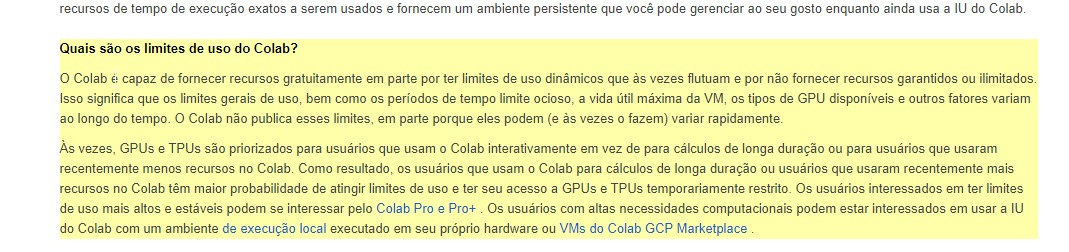

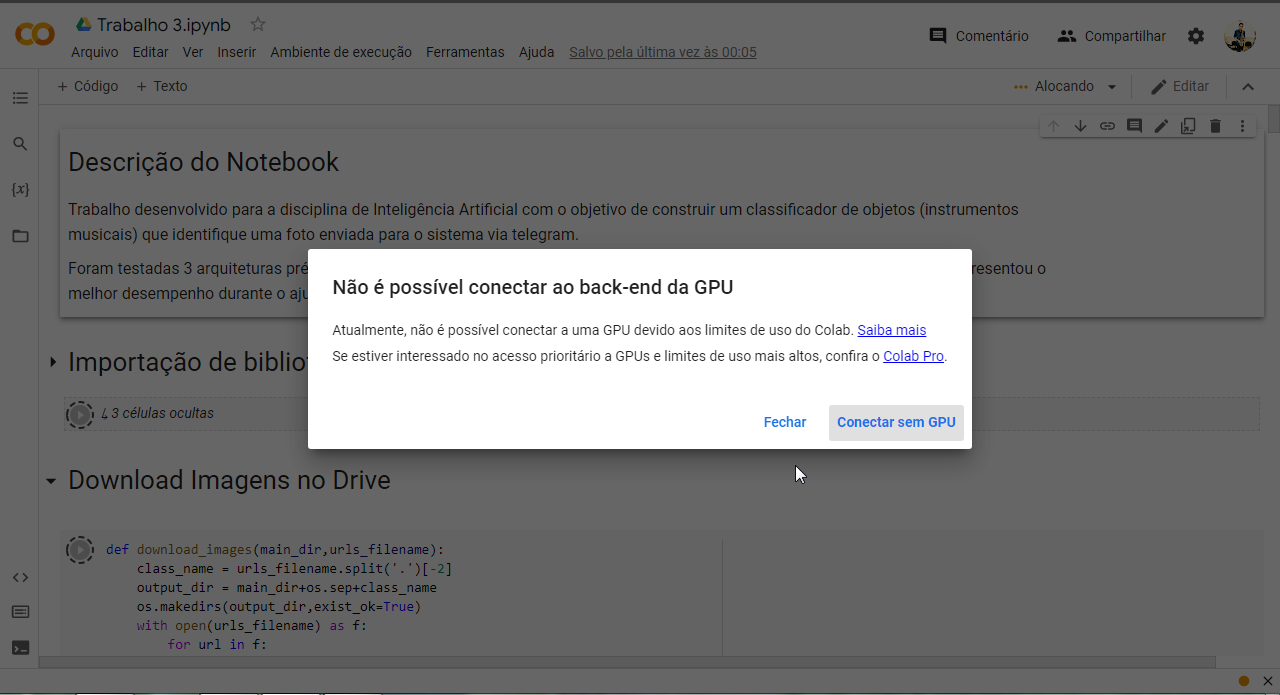